In [1]:
!pip install scikit-fuzzy

# Gym Dependencies
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

# Rendering Dependencies
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get install xvfb # install Xvfb
!pip install pyvirtualdisplay # install required package

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 50 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [2]:
#Importando as dependências
import gym
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import time

import pygame

# Initialize Pygame
pygame.init()

from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo # import RecordVideo instead of Monitor
gymlogger.set_level(40) #error only

import tensorflow as tf
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [3]:
###################Criando o Sistema Fuzzy#####################################

#Cria as variáveis do Sistema
posicao = ctrl.Antecedent(np.arange(-1.2,0.6,0.1), 'Posição')
velocidade = ctrl.Antecedent(np.arange(-0.07,0.07,0.001), 'Velocidade')

acao = ctrl.Consequent(np.arange(0,3,0.1), 'Ação')


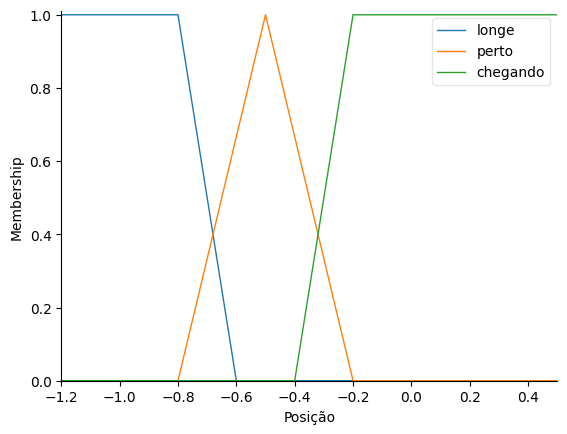

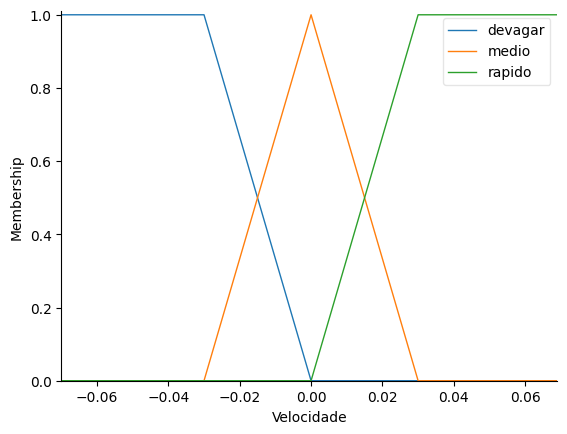

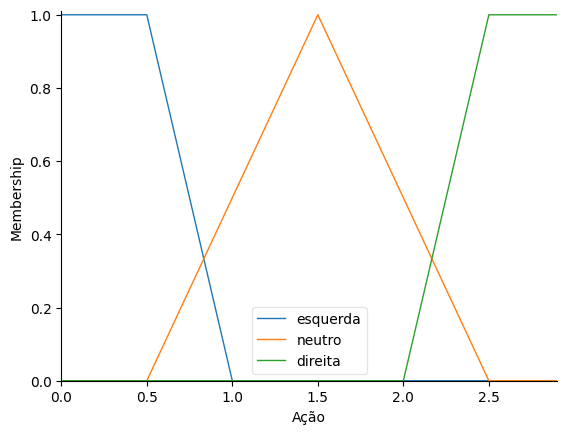

In [4]:
#Criar o sistema Fuzzy, para a Execução funcionar, chame sua simulação de controle de "disco"
#Variaveis de entrada

# Variáveis de entrada
posicao['longe'] = fuzz.trapmf(posicao.universe, [-1.2, -1.2, -0.8, -0.6])
posicao['perto'] = fuzz.trimf(posicao.universe, [-0.8, -0.5, -0.2])
posicao['chegando'] = fuzz.trapmf(posicao.universe, [-0.4, -0.2, 0.6, 0.6])
posicao.view()

velocidade['devagar'] = fuzz.trapmf(velocidade.universe, [-0.07, -0.07, -0.03, 0])
velocidade['medio'] = fuzz.trimf(velocidade.universe, [-0.03, 0, 0.03])
velocidade['rapido'] = fuzz.trapmf(velocidade.universe, [0, 0.03, 0.07, 0.07])
velocidade.view()

# Variável de saída
acao['esquerda'] = fuzz.trapmf(acao.universe, [0, 0, 0.5, 1])
acao['neutro'] = fuzz.trimf(acao.universe, [0.5, 1.5, 2.5])
acao['direita'] = fuzz.trapmf(acao.universe, [2, 2.5, 3, 3])
acao.view()


In [6]:
regra1 = ctrl.Rule(posicao['longe'] & velocidade['devagar'], acao['esquerda'])
regra2 = ctrl.Rule(posicao['longe'] & velocidade['medio'], acao['direita'])
regra3 = ctrl.Rule(posicao['longe'] & velocidade['rapido'], acao['direita'])
regra4 = ctrl.Rule(posicao['perto'] & velocidade['devagar'], acao['esquerda'])
regra5 = ctrl.Rule(posicao['perto'] & velocidade['medio'], acao['esquerda'])
regra6 = ctrl.Rule(posicao['perto'] & velocidade['rapido'], acao['direita'])
#regra7 = ctrl.Rule(posicao['chegando'] & velocidade['devagar'], acao['direita'])
regra8 = ctrl.Rule(posicao['chegando'] & velocidade['medio'], acao['direita'])
regra9 = ctrl.Rule(posicao['chegando'] & velocidade['rapido'], acao['direita'])

# Criar o sistema de controle
disco_ctrl = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6,regra8, regra9])
disco = ctrl.ControlSystemSimulation(disco_ctrl)

In [7]:
# Google Colab needs to render the environment to a virtual display
# we will record this as a video and play it after the training has finished
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video')
  return env

In [14]:
# env = gym.make('MountainCar-v0')

env = wrap_env(gym.make('MountainCar-v0'))

obs = env.reset() #reset the environment and see the initial observation

disco.input['Posição'] = obs[0]
disco.input['Velocidade'] = obs[1]

passo = 0

while True:
    time.sleep(0)
    passo += 1

    #total_reward = 0
    env.render() #rendenrização do ambiente a ser utilizado

    disco.compute()
    a = disco.output['Ação']
    if a < 1:
        a = 0
    elif a>2:
        a = 2
    else:
        a = 1
    #print(a)
    #print(obs)
    # obs, reward, terminate, truncated, _ = env.step(a) # Take the action and get the new observation space

    # The env.step(a) function returns 4 values, not 5
    obs, reward, terminate, _ = env.step(a) # Take the action and get the new observation space

    #Computando o Resultado
    disco.input['Posição'] = obs[0]
    disco.input['Velocidade'] = obs[1]
    print(f"Passo : ", passo)
    print(f"Posição do passo :", obs[0])
    print(f"Velocidade do Passo :", obs[1])
    print(f"Ação do passo: ", a)
    print()
    #total_reward += abs(obs[0] + 0.5)

    # if passo == 200:
        # obs = env.reset()
        # show_video()  #only shows the last run

    if terminate:

        break


env.close()

show_video()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Passo :  1
Posição do passo : -0.5163803
Velocidade do Passo : -0.0010620981
Ação do passo:  0

Passo :  2
Posição do passo : -0.5184965
Velocidade do Passo : -0.0021162324
Ação do passo:  0

Passo :  3
Posição do passo : -0.521651
Velocidade do Passo : -0.0031544978
Ação do passo:  0

Passo :  4
Posição do passo : -0.52582014
Velocidade do Passo : -0.004169106
Ação do passo:  0

Passo :  5
Posição do passo : -0.53097254
Velocidade do Passo : -0.005152446
Ação do passo:  0

Passo :  6
Posição do passo : -0.53706974
Velocidade do Passo : -0.0060971472
Ação do passo:  0

Passo :  7
Posição do passo : -0.54406583
Velocidade do Passo : -0.0069961427
Ação do passo:  0

Passo :  8
Posição do passo : -0.5519086
Velocidade do Passo : -0.007842736
Ação do passo:  0

Passo :  9
Posição do passo : -0.56053925
Velocidade do Passo : -0.008630668
Ação do passo:  0

Passo :  10
Posição do passo : -0.5698934
Velocidade do Passo : -0.009354181
Ação do passo:  0

Passo :  11
Posição do passo : -0.579901